In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
#from tsfresh import feature_extraction
%matplotlib inline
#import FATS
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('C:/Users/user/Desktop/VASYA4.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
df.tail()

,RTSI
month,
2017-08-01,1417
2017-09-01,1410
2017-10-01,1418
2017-11-01,1430
2017-12-01,1433


In [4]:
df.drop(df.index[239], inplace=True)

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    """
    y - ряд
    lags - количество отрезков на графиках корреляций

    """
    
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        ts_ax.set_xlabel(df.index.name)
        ts_ax.set_ylabel(df.columns[0])
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера")
        result = sm.tsa.stattools.adfuller(y)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
                


        plt.tight_layout()
    return 

# усредним прошлые значения

def moving_average(data, n):
    return np.average(data[-n:])

def plotMovingAverage(data, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = data.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(data[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    
    MSE_MA = mean_squared_error(data[(n-1):], data.rolling(window=n).mean()[(n-1):])
    
    print('MSE = ', MSE_MA)
    
# затра будет, как вчера

def plotLag(data):
    
    lag_data = data.shift(periods=1)
    
    plt.figure(figsize=(15,5))
    plt.title("Tomorrow as yesterday predictions")
    plt.plot(lag_data, "g", label="Lagged values")
    
    plt.plot(data, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlabel(df.index.name)
    plt.ylabel(df.columns[0])
    
    MSE_lag = mean_squared_error(data[1:], lag_data[1:])
    print('MSE = ', MSE_lag)
    return

Критерий Дики-Фуллера
ADF Statistic: -1.100277
p-value: 0.714961
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


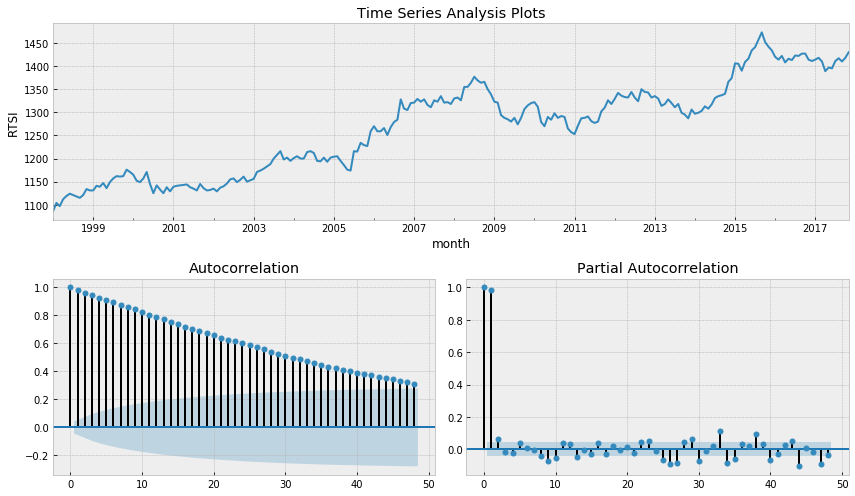

In [6]:
tsplot(df['RTSI'], lags=48)

In [7]:
"""
sm.tsa.seasonal_decompose(df.RTSI,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.RTSI)[1])
"""

'\nsm.tsa.seasonal_decompose(df.RTSI,period=12).plot()\ndef invboxcox(y,lmbda):\n   if lmbda == 0:\n      return(np.exp(y))\n   else:\n      return(np.exp(np.log(lmbda*y+1)/lmbda))\nprint("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.RTSI)[1])\n'

In [8]:
"""
df['stocks'], lmbda = stats.boxcox(pd.to_numeric(df.RTSI))
plt.figure(figsize(15,7))
df.stocks.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks)[1])
"""

'\ndf[\'stocks\'], lmbda = stats.boxcox(pd.to_numeric(df.RTSI))\nplt.figure(figsize(15,7))\ndf.stocks.plot()\nplt.ylabel(u\'RTSI\')\nprint("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)\nprint("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks)[1])\n'

In [9]:
"""
df['stocks_diff'] = df.stocks - df.stocks.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.stocks_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks_diff[12:])[1])
"""

'\ndf[\'stocks_diff\'] = df.stocks - df.stocks.shift(12)\nplt.figure(figsize(15,10))\nsm.tsa.seasonal_decompose(df.stocks_diff[12:],period=12).plot()\nprint("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks_diff[12:])[1])\n'

In [10]:
"""
df['stocks_diff2'] = df.stocks_diff - df.stocks_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.stocks_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks_diff2[13:])[1])
"""

'\ndf[\'stocks_diff2\'] = df.stocks_diff - df.stocks_diff.shift(1)\nplt.figure(figsize(15,10))\nsm.tsa.seasonal_decompose(df.stocks_diff2[13:],period=12).plot()   \nprint("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.stocks_diff2[13:])[1])\n'

Критерий Дики-Фуллера
ADF Statistic: -1.100277
p-value: 0.714961
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


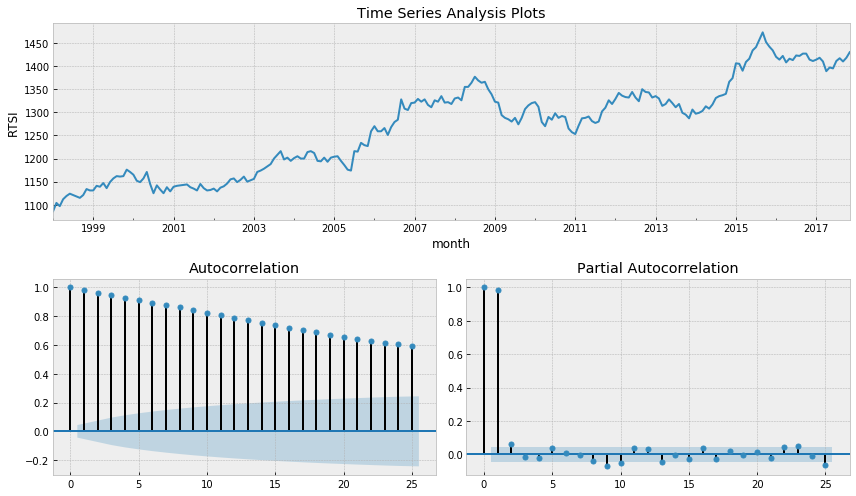

In [11]:
tsplot(df['RTSI'], lags=25)

MSE =  161.37014925373134


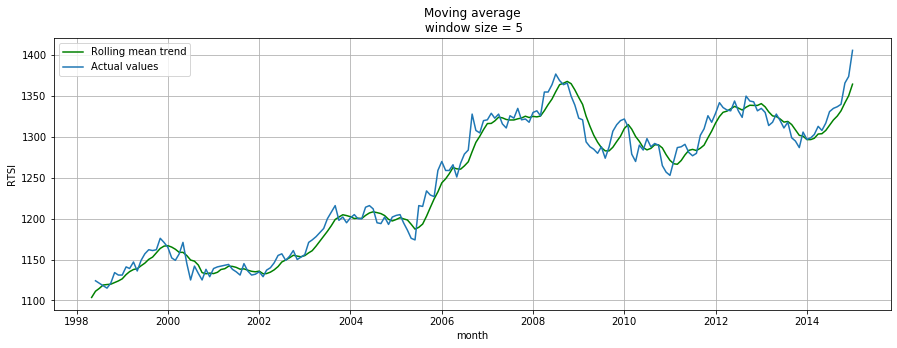

In [12]:
plotMovingAverage(df['RTSI'][:'2015-01-01'], n=5)

MSE =  136.2450980392157


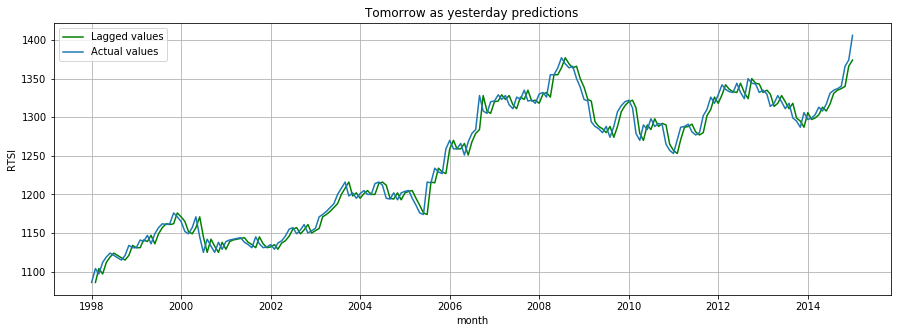

In [13]:
plotLag(df['RTSI'][:'2015-01-01'])

In [14]:
temps = pd.DataFrame(df.values)
dataframe = pd.concat([temps.shift(2), temps.shift(1)], axis=1)
dataframe.columns = ['t-2', 't-1']
dataframe.index = df.index
print(dataframe.head(10))

               t-2     t-1
month                     
1998-01-01     NaN     NaN
1998-02-01     NaN  1086.0
1998-03-01  1086.0  1104.0
1998-04-01  1104.0  1097.0
1998-05-01  1097.0  1112.0
1998-06-01  1112.0  1119.0
1998-07-01  1119.0  1124.0
1998-08-01  1124.0  1121.0
1998-09-01  1121.0  1118.0
1998-10-01  1118.0  1115.0


In [15]:
temps = pd.DataFrame(df.values)
shifted = temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
means.index = df.index
dataframe['mean(t-2,t-1)'] = means
print(dataframe.head(10))

               t-2     t-1  mean(t-2,t-1)
month                                    
1998-01-01     NaN     NaN            NaN
1998-02-01     NaN  1086.0            NaN
1998-03-01  1086.0  1104.0         1095.0
1998-04-01  1104.0  1097.0         1100.5
1998-05-01  1097.0  1112.0         1104.5
1998-06-01  1112.0  1119.0         1115.5
1998-07-01  1119.0  1124.0         1121.5
1998-08-01  1124.0  1121.0         1122.5
1998-09-01  1121.0  1118.0         1119.5
1998-10-01  1118.0  1115.0         1116.5


In [16]:
gbm = XGBRegressor()
res = gbm.fit(dataframe[:'2015-01-01'], df['RTSI'].loc[:'2015-01-01'])

Text(0, 0.5, 'RTSI')

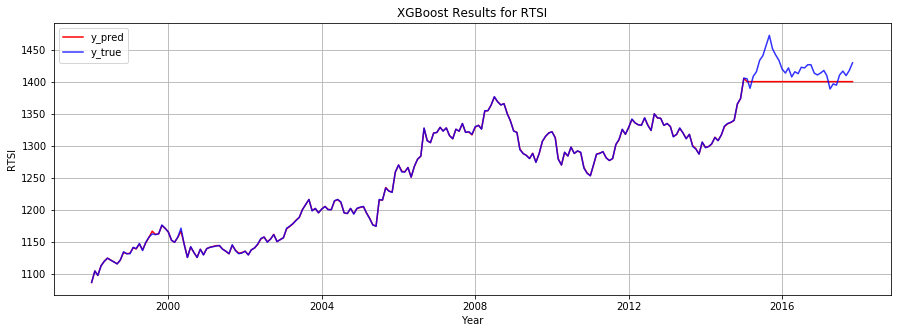

In [21]:
y_pred = pd.DataFrame(data=gbm.predict(dataframe))
y_pred.index = df.index

plt.figure(figsize=(15, 5))
plt.plot(y_pred, "red", label="y_pred")
plt.plot(df['RTSI'], "blue", alpha=0.8, label="y_true")
plt.axis('tight')
plt.grid(True)
# линия обозначает границу обучающей и тестовой выборок
plt.axvline(x=206, color='green',  linewidth=1, alpha=0.8)

plt.legend()
plt.title('XGBoost Results for RTSI')
plt.xlabel('Year')
plt.ylabel('RTSI')

In [19]:
mse_train = mean_squared_error(df.loc[:'2015-01-01'], y_pred[:'2015-01-01'])
mse_test = mean_squared_error(df.loc['2015-01-01':], y_pred['2015-01-01':])

print('MSE train = ', mse_train)
print('MSE test =', mse_test)

MSE train =  0.3943880958528053
MSE test = 676.6969514408282


In [ ]:
#y_pred[:207]

In [ ]:
#dataframe